<a href="https://colab.research.google.com/github/hwarang97/Dacon/blob/main/pytorch_tutorial/DACON_pytorch_day5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## reference 

url : https://dacon.io/codeshare/4551?page&dtype&ptype&fType

# AutoEncoder 만들어보기

In [ ]:
import google.colab.drive as drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from dacon_functions1 import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [ ]:
dataset_root = '/content/drive/MyDrive/Colab Notebooks/data'
BATCH_SIZE = 64
LR = 1e-3
EPOCH = 10
criterion = nn.MSELoss()
model_type = 'AutoEncoder'
data_type = 'FashionMNIST'
is_new_training = False
wanna_save = False
save_path = f'/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{data_type}.pt'

In [ ]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.ToTensor()
trainset = datasets.FashionMNIST(dataset_root, train=True, transform=transform_train, download=True)
testset = datasets.FashionMNIST(dataset_root, train=False, transform=transform_test, download=True)
train_DL = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_DL = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
x_batch, y_batch = next(iter(train_DL))
print(x_batch.shape)

torch.Size([64, 1, 28, 28])


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,100),
            nn.ReLU(),
            nn.Linear(100, 28*28)
        )
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        encoded = self.encoder(x) # latent variable
        decoded = self.decoder(encoded)
        decoded = decoded.reshape(-1,1,28,28)
        return encoded, decoded

In [ ]:
# model = AutoEncoder()
# x = torch.randn(64,1,28,28)
# out = model(x)
# print(out[1].shape)

In [ ]:
def Train2(model, train_DL, optimizer, criterion, BATCH_SIZE, EPOCH):
    model.train()
    NoT = len(train_DL)
    for epoch in range(1, EPOCH+1):
        e_loss = 0
        batch_count = 0

        for x_batch, label in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = x_batch.to(DEVICE)
            label = label.to(DEVICE)
            _, y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            b_loss = loss.item() * x_batch.shape[0]
            e_loss += b_loss
            batch_count += BATCH_SIZE

            if batch_count% (BATCH_SIZE*200) ==0:
                print(f'Train Epoch: {epoch} loss: {round(b_loss,5)}')

        print(f'epoch: {epoch}  Train_loss: {round(e_loss/NoT,5)}')
        print('-' * 25)

In [ ]:
def Test2(model, test_DL, criterion, BATCH_SIZE):
    model.eval()
    NoT = len(test_DL)
    e_loss = 0
    batch_count = 0

    with torch.no_grad():
        for x_batch, label in test_DL:
            x_batch, y_batch = x_batch.to(DEVICE), x_batch.to(DEVICE)
            _, y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            b_loss = loss.item() * x_batch.shape[0]
            e_loss += b_loss
            batch_count += BATCH_SIZE

            if batch_count%(BATCH_SIZE*200)==0:
                print(f'loss: {round(b_loss,5)}')

    print(f'Test_loss: {round(e_loss/NoT,5)}')
    print('-' * 25)

In [ ]:
def im_plot(model, test_DL):
    x_batch, label = next(iter(test_DL))
    for idx in range(3):
        title = test_DL.dataset.classes[label[idx]]
        plt.subplot(3,2, 1+(2*idx), xticks=[], yticks=[])
        plt.title('original_'+title)
        img = x_batch[idx].permute(1,2,0).squeeze()
        plt.imshow(img)

        plt.subplot(3,2, 2+(2*idx), xticks=[], yticks=[])
        plt.title('encoded_'+title)
        img = x_batch[idx]
        _, out = model(img)
        out = out.permute(0,2,3,1).squeeze().detach().numpy()
        plt.imshow(out)

In [ ]:
exec(f'model = {model_type}().to(DEVICE)')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if is_new_training:
    Train2(model, train_DL, optimizer, criterion, BATCH_SIZE, EPOCH)
    if wanna_save:
        torch.save(model, save_path)
else:
    model = torch.load(save_path, map_location=DEVICE)

Test2(model, test_DL, criterion, BATCH_SIZE)

Test_loss: 1.07382
-------------------------


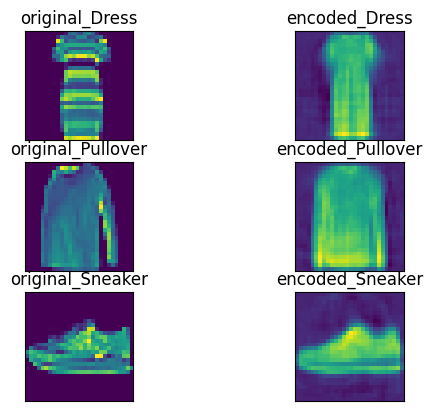

In [ ]:
im_plot(model, test_DL)

## <추가학습. 에러>

- The size of tensor a (784) must match the size of tensor b (28) at non-singleton dimension 3

- dimension 3 : (dim0, dim1, dim2, dim3) 에서 dim3를 의미
- loss를 계산할 때 입력과 출력의 크기가 맞지 않아서 생기는 문제로 보임
- flatten 후에 다시 28*28 꼴로 만들어주어야함

# 잠재변수 들여다 보기

In [ ]:
view_data = trainset.data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = model(test_x) # latent variables
encoded_data = encoded_data.to('cpu') # for plot

In [ ]:
print(encoded_data.shape)

torch.Size([200, 10])


In [ ]:
trainset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
# colab에서 진행하면 3D이미지는 안나옴

CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

# 10개 중에 3개만 뽑아서 표현한것뿐(3D한계)
X = encoded_data.data[:,0].numpy()
Y = encoded_data.data[:,1].numpy()
Z = encoded_data.data[:,2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name, backgroundcolor=color)
    
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

<Figure size 1000x800 with 0 Axes>

In [ ]:
print(type(encoded_data))
print(encoded_data.data)
print(trainset.targets)

<class 'torch.Tensor'>
tensor([[ 2.5619,  0.9644, -1.3432,  ..., -0.8437,  0.3215, -1.5253],
        [-0.7913, -3.2666, -3.1065,  ...,  5.2013,  2.3099,  0.7971],
        [-0.4534, -0.7622, -0.4335,  ...,  2.4231,  1.6806,  1.0764],
        ...,
        [ 3.6009, -3.9682, -2.1530,  ...,  3.9132,  0.0694, -1.6144],
        [ 0.9787,  0.7055, -0.7647,  ..., -0.7460,  0.1392, -0.9923],
        [ 1.7642, -2.5349, -1.2747,  ...,  3.7737,  0.7247, -0.3619]])
tensor([9, 0, 0,  ..., 3, 0, 5])


# 이미지 복원

In [ ]:
BATCH_SIZE = 64
LR = 2e-3
EPOCH = 10
criterion = nn.MSELoss()
model_type = 'AutoEncoder'
data_type = 'FashionMNIST'
is_new_training = False
wanna_save = False
save_path = f'/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{data_type}_noised.pt'

In [ ]:
def add_noise(img): # noise 추가
    noise = torch.randn(img.shape) * 0.2
    img = img + noise
    return img

In [ ]:
def Train_noise(model, train_DL, optimizer, criterion, BATCH_SIZE, EPOCH):
    model.train()
    NoT = len(train_DL)
    for epoch in range(1, EPOCH+1):
        e_loss = 0
        batch_count = 0

        for x_batch, label in train_DL:
            x_batch = x_batch.to(DEVICE)
            x_batch = add_noise(x_batch)
            y_batch = x_batch.to(DEVICE)
            label = label.to(DEVICE)
            _, y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            b_loss = loss.item() * x_batch.shape[0]
            e_loss += b_loss
            batch_count += BATCH_SIZE

            if batch_count% (BATCH_SIZE*200) ==0:
                print(f'Train Epoch: {epoch} loss: {round(b_loss,5)}')

        print(f'epoch: {epoch}  Train_loss: {round(e_loss/NoT,5)}')
        print('-' * 25)

In [ ]:
def Test_noise(model, test_DL, criterion, BATCH_SIZE):
    model.eval()
    NoT = len(test_DL)
    e_loss = 0
    batch_count = 0

    with torch.no_grad():
        for x_batch, label in test_DL:
            x_batch, y_batch = x_batch.to(DEVICE), x_batch.to(DEVICE)
            x_batch = add_noise(x_batch)
            _, y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            b_loss = loss.item() * x_batch.shape[0]
            e_loss += b_loss
            batch_count += BATCH_SIZE

            if batch_count%(BATCH_SIZE*200)==0:
                print(f'loss: {round(b_loss,5)}')

    print(f'Test_loss: {round(e_loss/NoT,5)}')
    print('-' * 25)

In [ ]:
def noised_im_plot(model, test_DL):
    x_batch, label = next(iter(test_DL))
    for idx in range(3):
        title = test_DL.dataset.classes[label[idx]]
        plt.subplot(3,2, 1+(2*idx), xticks=[], yticks=[])
        plt.title('noised_'+title)
        img = add_noise(x_batch[idx]) 
        img_whc = img.permute(1,2,0).squeeze() # noise_img
        plt.imshow(img_whc)
        

        plt.subplot(3,2, 2+(2*idx), xticks=[], yticks=[])
        plt.title('recoverd_'+title)
        _, out = model(img) # recovered_img
        out = out.permute(0,2,3,1).squeeze().detach().numpy()
        plt.imshow(out)
        

In [ ]:
# x_batch, label = next(iter(test_DL))
# img = add_noise(x_batch[idx]).permute(1,2,0).squeeze()
# plt.imshow(img)

Test_loss: 1.18822
-------------------------


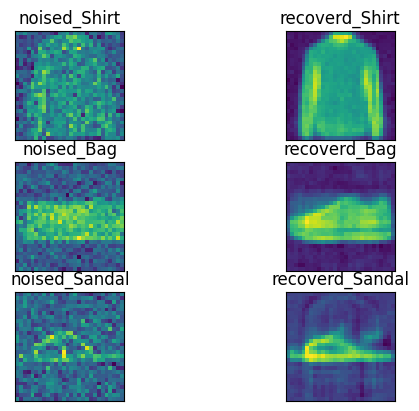

In [ ]:
exec(f'model = {model_type}().to(DEVICE)')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)



if is_new_training:
    Train_noise(model, train_DL, optimizer, criterion, BATCH_SIZE, EPOCH)
    if wanna_save:
        torch.save(model, save_path)
else:
    model = torch.load(save_path, map_location=DEVICE)
Test_noise(model, test_DL, criterion, BATCH_SIZE)
noised_im_plot(model, test_DL)